# Aeolus Level 1B product
## Aeolus preliminary horizontal line-of-sight wind observations and useful signals

> Abstract: Access to level 1B product and its visualization

## Load packages, modules and extensions

In [1]:
# enable following line for interactive visualization backend for matplotlib
# %matplotlib widget
# print version info
%load_ext watermark
%watermark -i -v -p viresclient,pandas,xarray,matplotlib

Python implementation: CPython
Python version       : 3.11.6
IPython version      : 8.18.0

viresclient: 0.11.3
pandas     : 2.1.3
xarray     : 2023.12.0
matplotlib : 3.8.2



In [2]:
from viresclient import AeolusRequest
import numpy as np
from netCDF4 import num2date
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import cartopy.crs as ccrs
from ipywidgets import interact
import ipywidgets as widgets
import warnings
warnings.filterwarnings(action='ignore', message='Mean of empty slice')

## Product information

The Level 1B wind product of the Aeolus mission contains the preliminary HLOS (horizontal line-of-sight) wind observations and useful signals for Rayleigh and Mie receivers, which are generated in Near Real Time (NRT) within 3 hours after data acquisition.

Documentation:
- https://earth.esa.int/eogateway/catalog/aeolus-preliminary-hlos-horizontal-line-of-sight-wind-observations-for-rayleigh-and-mie-receivers



### L1B parameters on VirES

Many of the parameters of the L1B product can be obtained from the viresclient. A list of selected parameters can be found in the following table. For a complete list, please refer to the web client which lists the available parameters under the "Data" tab. For an explanation of the parameters, please refer to the VirES web client or the documentation (link above).
Some parameters are available specifically for Rayleigh or Mie measurements (e.g. HLOS winds), others are independent of the measurement method and universally applicable (e.g. time). There is also a distinction between observations and measurements, with 30 measurements being averaged to one observation. A description of the parameters in the table is shown as tooltip when hovering the parameter name.

| Parameter | Observation type <br> Rayleigh | Observation type <br> Mie | Observation type <br> independent | Granularity <br> observation | Granularity <br> measurement |
|:----------|:------------------------------:|:-------------------------:|:--------------------------:|:----------------------------:|:----------------------------:|
|[time](## "UTC Time at center of obs/meas")              |   |   | X | X | X |
|[altitude](## "Altitude of height bins with respect to the WGS84 ellipsoid along the line-of-sight")          | X | X |   | X | X |
|[latitude](## "Latitude of each height bin along the line-of-sight")          | X | X |   | X | X |
|[longitude](## "Longitude of each height bin along the line-of-sight")         | X | X |   | X | X |
|[longitude_of_DEM_intersection](## "Longitude of the intersection of DEM and the line-of-sight")         |   |   | X | X | X |
|[latitude_of_DEM_intersection](## "Latitude of the intersection of DEM and the line-of-sight")         |   |   | X | X | X |
|[altitude_of_DEM_intersection](## "Altitude of the intersection of DEM and the line-of-sight")         |   |   | X | X | X |
|[range](## "Distance along the LOS between the instrument and the lower edge of the height bin")             | X | X |   | X |   |
|[HLOS_wind_speed](## "Vertical profiles of HLOS winds")   | X | X |   | X | X |
|[signal_intensity](## "Vertical profiles of signal intensity")  | X | X |   | X | X |
|[signal_channel_A_intensity](## "Vertical profiles of signal intensity of Rayleigh channel A") | X |   |   | X | X |
|[signal_channel_B_intensity](## "Vertical profiles of signal intensity of Rayleigh channel B") | X |   |   | X | X |
|[SNR](## "Vertical profiles of signal-to-noise ratio")               | X | X |   | X | X |
|[channel_A_SNR](## "Vertical profiles of signal-to-noise for the Rayleigh channel A")     | X |   |   | X | X |
|[channel_B_SNR](## "Vertical profiles of signal-to-noise for the Rayleigh channel B")     | X |   |   | X | X |
|[bin_quality_flag](## "Bin quality flag")  | X | X |   | X | X |
|[geoid_separation](## "Height of geoid above WGS84 ellipsoid")  |   |   | X | X | X |
|[scattering_ratio](## "Vertical profiles of the scattering ratio for the Mie channel")  |   | X |   | X | X |
|[average_laser_energy](## "Average laser pulse UV energy of N * (P – 1) pulses") |   |   | X | X | X |

## Defining product, parameters and time for the data request
Keep in mind that the time for **one full orbit** is around **90 minutes**.
The **repeat cycle** of the orbits is **7 days**.

In [3]:
# Aeolus product
DATA_PRODUCT = "ALD_U_N_1B"

# measurement period in yyyy-mm-ddTHH:MM:SS
measurement_start = "2020-10-21T00:00:00Z"
measurement_stop = "2020-10-21T00:30:00Z"

# Product parameters to retrieve
# uncomment parameters of interest

# Rayleigh observation level
parameter_rayleigh_observations = [
    "altitude",
    "latitude",
    "longitude",
    "range",
    # "HLOS_wind_speed",
    "signal_intensity",
    # "signal_intensity_normalised",
    # "signal_channel_A_intensity",
    # "signal_channel_B_intensity",
    "bin_quality_flag",
    "SNR",
]
parameter_rayleigh_observations = ["rayleigh_" + param for param in parameter_rayleigh_observations]

# Rayleigh measurement level
parameter_rayleigh_measurements = [
    "altitude",
    "latitude",
    "longitude",
    # "HLOS_wind_speed",
    "signal_intensity",
    # "signal_intensity_normalised",
    # "signal_channel_A_intensity",
    # "signal_channel_B_intensity",
    "bin_quality_flag",
    "SNR",
]
parameter_rayleigh_measurements = ["rayleigh_" + param for param in parameter_rayleigh_measurements]

# Mie observation level
parameter_mie_observations = [
    "altitude",
    "latitude",
    "longitude",
    "range",
    # "HLOS_wind_speed",
    "signal_intensity",
    # "signal_intensity_normalised",
    "bin_quality_flag",
    "SNR",
]
parameter_mie_observations = ["mie_" + param for param in parameter_mie_observations]

# Mie measurement level
parameter_mie_measurements = [
    "altitude",
    "latitude",
    "longitude",
    # "HLOS_wind_speed",
    "signal_intensity",
    # "signal_intensity_normalised",
    "bin_quality_flag",
    "SNR",
]
parameter_mie_measurements = ["mie_" + param for param in parameter_mie_measurements]

# Observation type independent parameters observations level
parameter_observations_indepdendent = ["time", "altitude_of_DEM_intersection"]

# Observation type independent parameters measurement level
parameter_measurements_independent = ["time", "altitude_of_DEM_intersection"]

# Combine parameters to one list for observation and one for measurement level
parameter_list_observations = (
    parameter_rayleigh_observations
    + parameter_mie_observations
    + parameter_observations_indepdendent
)
parameter_list_measurements = (
    parameter_rayleigh_measurements
    + parameter_mie_measurements
    + parameter_measurements_independent
)

## Retrieve data from VRE server

In [4]:
# Data request for observation level
# check if observation parameter list is not empty
if len(parameter_list_observations) > 0:

    request = AeolusRequest()

    request.set_collection(DATA_PRODUCT)

    # set observation fields
    request.set_fields(
        observation_fields=parameter_list_observations,
    )

    # set start and end time and request data
    data_observation = request.get_between(
        start_time=measurement_start, end_time=measurement_stop, filetype="nc", asynchronous=True
    )

Processing:    0%|          |  [ Elapsed: 00:00, Remaining: ? ] [1/1] 

Downloading:   0%|          |  [ Elapsed: 00:00, Remaining: ? ] (0.544MB)

In [5]:
# Data request for measurement level
# check if measurement parameter list is not empty
if len(parameter_list_measurements) > 0:

    request = AeolusRequest()

    request.set_collection(DATA_PRODUCT)

    # set measurement fields
    request.set_fields(
        measurement_fields=parameter_list_measurements,
    )

    # set start and end time and request data
    data_measurement = request.get_between(
        start_time=measurement_start, end_time=measurement_stop, filetype="nc", asynchronous=True
    )

Processing:    0%|          |  [ Elapsed: 00:00, Remaining: ? ] [1/1] 

Downloading:   0%|          |  [ Elapsed: 00:00, Remaining: ? ] (12.099MB)

In [6]:
# Save data as xarray data sets
# check if variable is assigned
if 'data_observation' in globals():
    ds_observations = data_observation.as_xarray()
if 'data_measurement' in globals():
    ds_measurements = data_measurement.as_xarray()

## Plot overview map

Text(0.5, 1.0, 'Aeolus orbit \n from 2020-10-21T00:00:00Z to 2020-10-21T00:30:00Z')

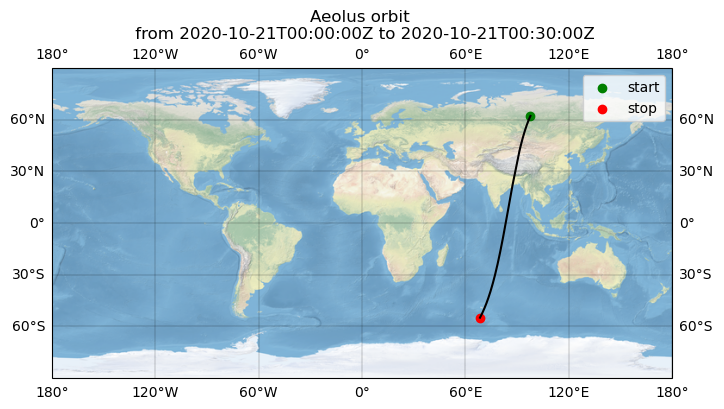

In [7]:
fig = plt.figure(figsize=(8, 6))
ax = fig.add_subplot(1, 1, 1, projection=ccrs.PlateCarree())
ax.stock_img()
gl = ax.gridlines(draw_labels=True, linewidth=0.3, color="black", alpha=0.5, linestyle="-")
ax.plot(
    ds_observations["rayleigh_longitude"][:, -1],
    ds_observations["rayleigh_latitude"][:, -1],
    "k-",
    transform=ccrs.Geodetic(),
)
ax.scatter(
    ds_observations["rayleigh_longitude"][0, -1],
    ds_observations["rayleigh_latitude"][0, -1],
    marker="o",
    c="g",
    edgecolor="g",
    label="start",
    transform=ccrs.Geodetic(),
)
ax.scatter(
    ds_observations["rayleigh_longitude"][-1, -1],
    ds_observations["rayleigh_latitude"][-1, -1],
    marker="o",
    c="r",
    edgecolor="r",
    label="stop",
    transform=ccrs.Geodetic(),
)
ax.legend()
ax.set_title("Aeolus orbit \n from {} to {}".format(measurement_start, measurement_stop))

## Add datetime variable to the data sets

In [8]:
if "ds_measurements" in globals():
    ds_measurements["datetime"] = (
        ("measurement"),
        num2date(
            ds_measurements["time"], units="s since 2000-01-01", only_use_cftime_datetimes=False
        ),
    )
if "ds_observations" in globals():
    ds_observations["datetime"] = (
        ("observation"),
        num2date(
            ds_observations["time"], units="s since 2000-01-01", only_use_cftime_datetimes=False
        ),
    )

## Extract bits from bin_quality_flag and add them to the data sets for QC
The first bit in the L1B-bin-quality-flag is the overall validity flag.
Please see documentation (IODD) for more information on the bin quality flag.

In [9]:
if "ds_observations" in globals():
    ds_observations["rayleigh_validity_flags"] = (
        ("observation", "array_24", "array_16"),
        np.flip(
            np.unpackbits(
                ds_observations["rayleigh_bin_quality_flag"][:, :].values.view(np.uint8),
                bitorder="little",
            ).reshape([-1, 24, 16]),
            axis=-1,
        ),
    )
    ds_observations["mie_validity_flags"] = (
        ("observation", "array_24", "array_16"),
        np.flip(
            np.unpackbits(
                ds_observations["mie_bin_quality_flag"][:, :].values.view(np.uint8),
                bitorder="little",
            ).reshape([-1, 24, 16]),
            axis=-1,
        ),
    )

if "ds_measurements" in globals():
    ds_measurements["rayleigh_validity_flags"] = (
        ("measurement", "array_24", "array_16"),
        np.flip(
            np.unpackbits(
                ds_measurements["rayleigh_bin_quality_flag"][:, :].values.view(np.uint8),
                bitorder="little",
            ).reshape([-1, 24, 16]),
            axis=-1,
        ),
    )
    ds_measurements["mie_validity_flags"] = (
        ("measurement", "array_24", "array_16"),
        np.flip(
            np.unpackbits(
                ds_measurements["mie_bin_quality_flag"][:, :].values.view(np.uint8),
                bitorder="little",
            ).reshape([-1, 24, 16]),
            axis=-1,
        ),
    )

## Calculate additional parameters
The range corrected (r²-dependency) and normalized (accounting for different range bin thickness) signal can be calculated.

In [10]:
# compute range corrected and normalized signal intensities
# compute range to bin center and range bin thickness
for parameter in ds_observations:
    if "range" in parameter:
        # range bin thickness
        ds_observations[parameter + "_bin_thickness"] = (
            ("observation", "array_24"),
            ds_observations[parameter].diff(dim="array_25").data,
        )
        # range to bin center
        range_to_bin_center = (
            ds_observations[parameter][:, 1:].data
            - 0.5 * ds_observations[parameter + "_bin_thickness"].data
        )
        ds_observations[parameter + "_to_bin_center"] = (
            ("observation", "array_24"),
            range_to_bin_center,
        )
        ds_observations[parameter + "_to_bin_center"] = (
            ("observation", "array_24"),
            range_to_bin_center,
        )

# apply range correction and normalization by smallest possible range bin for observation level
# smallest range bin along line of sight is 315.407 meter
# add altitude for range bin center
if "ds_observations" in globals():
    # observation altitude for range bin center
    ds_observations["rayleigh_altitude_bin_center"] = (
        ("observation", "array_24"),
        ds_observations["rayleigh_altitude"][:, 1:].data
        - ds_observations["rayleigh_altitude"].diff(dim="array_25").data / 2.0,
    )
    ds_observations["mie_altitude_bin_center"] = (
        ("observation", "array_24"),
        ds_observations["mie_altitude"][:, 1:].data
        - ds_observations["mie_altitude"].diff(dim="array_25").data / 2.0,
    )
    for parameter in ds_observations:
        if "signal_intensity" in parameter:
            obs_type = parameter.split("_")[0]
            signal_intensity_rc_normalized = (
                ds_observations[parameter].data[:, :-1]
                * (ds_observations[obs_type + "_range_to_bin_center"].data ** 2)
                * (315.407 / ds_observations[obs_type + "_range_bin_thickness"].data)
            )
            ds_observations[parameter + "_rc_normalized"] = (
                ("observation", "array_24"),
                signal_intensity_rc_normalized,
            )

# apply range correction and normalization by smallest possible range bin for measurement level
# smallest range bin along line of sight is 315.407 meter
# add altitude for range bin center
if "ds_measurements" in globals():
    # measurement altitude for range bin center
    ds_measurements["rayleigh_altitude_bin_center"] = (
        ("measurement", "array_24"),
        ds_measurements["rayleigh_altitude"][:, 1:].data
        - ds_measurements["rayleigh_altitude"].diff(dim="array_25").data / 2.0,
    )
    ds_measurements["mie_altitude_bin_center"] = (
        ("measurement", "array_24"),
        ds_measurements["mie_altitude"][:, 1:].data
        - ds_measurements["mie_altitude"].diff(dim="array_25").data / 2.0,
    )
    num_meas_per_obs = int(ds_measurements.dims['measurement']/ds_observations.dims['observation'])
    for parameter in ds_measurements:
        if "signal_intensity" in parameter:
            obs_type = parameter.split("_")[0]
            signal_intensity_rc_normalized = (
                ds_measurements[parameter].data[:, :-1]
                * (ds_observations[obs_type + "_range_to_bin_center"].data.repeat(num_meas_per_obs, axis=0) ** 2)
                * (
                    315.407
                    / ds_observations[obs_type + "_range_bin_thickness"].data.repeat(num_meas_per_obs, axis=0)
                )
            )
            ds_measurements[parameter + "_rc_normalized"] = (
                ("measurement", "array_24"),
                signal_intensity_rc_normalized,
            )

/opt/conda/lib/python3.11/site-packages/xarray/core/utils.py:494: FutureWarning: The return type of `Dataset.dims` will be changed to return a set of dimension names in future, in order to be more consistent with `DataArray.dims`. To access a mapping from dimension names to lengths, please use `Dataset.sizes`.
  warnings.warn(


## Plot parameter
A class for filtering and interactive plotting of L1B data.

In [11]:
class PlotData:
    """
    Class for plotting L1B data

    Parameters
    ----------
    granularity : string
        Which granularity to plot. Can be 'measurement' or 'observation'.
    """

    def __init__(self, granularity):
        self.granularity = granularity
        self.ds = self.select_dataset()

    def select_dataset(self):
        """Selects the dataset dependent on the L1B granularity"""
        dataset_dict = {
            "measurement": ds_measurements, "observation": ds_observations
        }
        return dataset_dict[self.granularity]

    def select_parameter(self, parameter):
        """Selects the parameter data for plotting and sets the
        product/channel depending on the parameter."""
        self.parameter = parameter
        self.parameter_data = np.copy(self.ds[parameter].data)
        if self.parameter_data.shape[1] == 25:
            self.parameter_data = self.parameter_data[:, :-1]
        if hasattr(self.ds[parameter], 'units'):
            self.parameter_unit = self.ds[parameter].units
        else:
            self.parameter_unit = 'a.u.'
        # distinguish between SCA and SCA_middle_bin
        if "rayleigh" in parameter:
            self.product = "rayleigh"
        elif "mie" in parameter:
            self.product = "mie"

    def select_validity_flag(self):
        """Select the corresponding validity flag for the product"""
        if self.product == "rayleigh":
            validity_flag = self.ds["rayleigh_validity_flags"]
        elif self.product == "mie":
            validity_flag = self.ds["mie_validity_flags"]
        return validity_flag.data

    def select_SNR_parameter(self):
        """Select the corresponding SNR parameter for the product"""
        if self.product == "rayleigh":
            SNR = self.ds["rayleigh_SNR"][:, :-1]
        elif self.product == "mie":
            SNR = self.ds["mie_SNR"][:, :-1]
        return SNR.data

    def apply_QC_filter(self):
        """
        Applies the QC filter depending on validity flag.
        The first bit of the validity flag is the overall validity.
        1 = invalid, 0 = valid
        """
        validity_flag = self.select_validity_flag()
        self.parameter_data[validity_flag[:, :, 0] == 1] = np.nan

    def apply_SNR_filter(self, SNR_threshold):
        """Applies a filter depending on SNR values"""
        SNR = self.select_SNR_parameter()
        # Create SNR mask based on threshold
        SNR_mask = SNR < SNR_threshold
        self.parameter_data[SNR_mask] = np.nan

    def determine_vmin_vmax(self, z, vmin=None, vmax=None, percentile=99):
        """
        Determines limit values for plots

        """
        if vmin is None:
            vmin = 0
        if vmax is None:
            vmax = np.nanpercentile(z, percentile)
        return vmin, vmax

    def determine_xyz(self, start_bin, end_bin):
        """
        Determines time parameter (x), altitude parameter (y) and
        parameter of interest (z) for the pcolormesh plot.
        The parameters are sliced according to start_bin and end_bin.
        Altitude parameter is scaled to km instead of m.
        """
        x = self.ds["datetime"][start_bin:end_bin]
        if self.product == "rayleigh":
            y = self.ds["rayleigh_altitude"][start_bin:end_bin] / 1000.0
            y_profile = self.ds["rayleigh_altitude_bin_center"][start_bin:end_bin] / 1000.0
        elif self.product == "mie":
            y = self.ds["mie_altitude"][start_bin:end_bin] / 1000.0
            y_profile = self.ds["mie_altitude_bin_center"][start_bin:end_bin] / 1000.0
        z = self.parameter_data[start_bin:end_bin]
        return x, y, z, y_profile

    def determine_xy(self, profile_time, no_profiles_avg):
        """
        Determines closest profile to the profile time of interest.
        Selects the corresponding altitude (x) and profile of parameter of
        interest (y) with optional averaging (no_profiles_avg).
        """
        time_data = self.ds["datetime"]
        profile_id = np.argmin(np.abs(time_data.data - np.datetime64(profile_time)))

        if self.product == "rayleigh":
            x = self.ds["rayleigh_altitude_bin_center"][profile_id][1:] / 1000.0
        elif self.product == "mie":
            x = self.ds["mie_altitude_bin_center"][profile_id][1:] / 1000.0
        y = np.mean(
            self.parameter_data[
                profile_id - int(no_profiles_avg / 2):profile_id + int(no_profiles_avg / 2) + 1, :
            ],
            axis=0,
        )
        return x, y

    def get_DEM_altitude_data(self, start_bin, end_bin):
        """
        Selects the DEM altitude.
        """
        DEM_altitude = self.ds["altitude_of_DEM_intersection"] / 1000.0
        return DEM_altitude[start_bin:end_bin]

    def get_geolocation_data(self, start_bin, end_bin):
        """
        Selects latitude and longitude parameters for map plot.
        """
        if self.product == "rayleigh":
            latitude = self.ds["rayleigh_latitude"][:, -1]
            longitude = self.ds["rayleigh_longitude"][:, -1]
        elif self.product == "mie":
            latitude = self.ds["mie_latitude"][:, -1]
            longitude = self.ds["mie_longitude"][:, -1]

        return latitude[start_bin:end_bin], longitude[start_bin:end_bin]

    def prepare_gaps_for_plot(self, x):
        """
        In order to show gaps in the data in an pcolormesh plot as white space
        instead of interpolated values the borders of the gaps where data is 
        still available needs to be set to nan values.
        This function creates such a mask based on the "time" parameter which
        should be the x-parameter of the function.
        """
        if self.granularity == "measurement":
            time_diff = 1.5
        elif self.granularity == "observation":
            time_diff = 13.0

        mask_for_gaps = np.diff(x, axis=0).astype("float") / 1e9 > time_diff
        return mask_for_gaps

    def draw_2D(self, fig, ax, x, y, z, vmin, vmax, DEM_altitude_data):
        """Draws a 2D curtain plot with the pcolormesh routine"""
        # In order to show gaps in the pcolormesh plot as white space instead of interpolated values
        # a nan mask is created and applied to the z parameter.
        # x must be the time parameter
        mask_for_gaps = self.prepare_gaps_for_plot(x)
        z[:-1, :][mask_for_gaps] = np.nan
        z[1:, :][mask_for_gaps] = np.nan
        im = ax.pcolormesh(x, y.T, z[:-1, :].T, vmin=vmin, vmax=vmax, cmap="viridis")
        if DEM_altitude_data is not None:
            ax.plot(x, DEM_altitude_data, "r-", label="DEM altitude")
        ax.set_ylim(-1, 25)
        ax.set_xlabel("Date [UTC]")
        ax.set_ylabel("Altitude [km]")
        ax.set_title("{} - {}".format(self.product, self.parameter))
        ax.grid()
        ax.legend()
        locator = mdates.AutoDateLocator(minticks=4, maxticks=8)
        formatter = mdates.ConciseDateFormatter(locator)
        ax.xaxis.set_major_locator(locator)
        ax.xaxis.set_major_formatter(formatter)
        fig.colorbar(im, ax=ax, aspect=50, pad=0.001, label=self.parameter_unit)

    def draw_profile(self, ax, x, y, vmin, vmax, ymin, ymax, profile_time):
        """Draws a profile plot"""
        ax.plot(y, x, "ro-")
        ax.set_xlim(vmin, vmax)
        ax.set_ylim(ymin, ymax)
        ax.grid()
        ax.set_ylabel("Altitude [km]")
        ax.set_xlabel(f"{self.parameter} [{self.parameter_unit}]")
        ax.set_title("{} - {} \n at {}".format(self.product, self.parameter, profile_time))

    def draw_map(self, ax, lat, lon):
        """Draws a map with cartopy"""
        ax.stock_img()
        gl = ax.gridlines(draw_labels=True, linewidth=0.3, color="black", alpha=0.5, linestyle="-")
        ax.scatter(
            lon,
            lat,
            marker="o",
            c="k",
            s=5,
            transform=ccrs.Geodetic(),
        )

    def plot_2D(self, vmin=None, vmax=None, start_bin=0, end_bin=-1, DEM_altitude=True):
        """
        Create 2D curtain plot
        """
        x, y, z, y_profile = self.determine_xyz(start_bin, end_bin)
        vmin, vmax = self.determine_vmin_vmax(z, vmin, vmax, 90)
        if DEM_altitude:
            DEM_altitude_data = self.get_DEM_altitude_data(start_bin, end_bin)
        else:
            DEM_altitude = None
        fig, ax = plt.subplots(1, 1, figsize=(10, 6), constrained_layout=True)
        self.draw_2D(fig, ax, x, y, z, vmin, vmax, DEM_altitude_data)

    def plot_profile(self, profile_time, no_profiles_avg, vmin=None, vmax=None, ymin=-1, ymax=25):
        """
        Create profile plot
        """
        x, y = self.determine_xy(profile_time, no_profiles_avg)
        vmin, vmax = self.determine_vmin_vmax(y, vmin, vmax, 100)
        vmin = -vmax / 10.0
        fig, ax = plt.subplots(1, 1, figsize=(6, 10), constrained_layout=True)
        self.draw_profile(ax, x, y, vmin, vmax, ymin, ymax, profile_time)

    def plot_interactive(self, vmin=None, vmax=None, start_bin=0, end_bin=-1, DEM_altitude=True):
        """
        Create interactive plot with 2D curtain plot, profile plot and map plot by using ipywidgets
        """
        self.fig = plt.figure(figsize=(10, 10))  # , constrained_layout=True)
        gs = self.fig.add_gridspec(2, 4)
        self.ax_2D = self.fig.add_subplot(gs[0:1, :-1])
        self.ax_map = self.fig.add_subplot(gs[1:, 0:], projection=ccrs.PlateCarree())
        self.ax_profile = self.fig.add_subplot(gs[0:1, -1], sharey=self.ax_2D)

        self.x, self.y, self.z, self.y_profile = self.determine_xyz(start_bin, end_bin)
        vmin, vmax = self.determine_vmin_vmax(self.z, vmin, vmax, 90)
        if DEM_altitude:
            DEM_altitude_data = self.get_DEM_altitude_data(start_bin, end_bin)
        else:
            DEM_altitude = None
        self.latitude, self.longitude = self.get_geolocation_data(start_bin, end_bin)
        self.draw_2D(self.fig, self.ax_2D, self.x, self.y, self.z, vmin, vmax, DEM_altitude_data)
        self.draw_map(self.ax_map, self.latitude, self.longitude)
        profile_id = [(str(i), j) for j, i in enumerate(self.x.data)]
        self.vline = None
        self.profile_geolocation = None
        self.draw_interactive(10, 1)
        self.ax_map.legend()
        self.ax_2D.legend()
        self.fig.tight_layout()

        interact(
            self.draw_interactive,
            no_profiles_avg=widgets.IntSlider(
                value=1,
                min=1,
                max=30,
                step=2,
                continuous_update=False,
                layout={"width": "500px"},
                description="Profiles to average",
                style={"description_width": "initial"},
            ),
            profile_id=widgets.SelectionSlider(
                options=profile_id[0:-1],
                value=profile_id[10][1],
                continuous_update=False,
                layout={"width": "500px"},
                description="Profile time",
                style={"description_width": "initial"},
            ),
        )

    def draw_interactive(self, profile_id, no_profiles_avg):
        """
        Function which can be called interactively to draw 2D plot,
        profile plot and map plot.
        It updates the selected profile marker in the 2D- and map plot and
        calculates the mean profile to create the profile plot.
        """
        x = self.y_profile[profile_id][:]
        y = np.nanmean(
            self.z[
                profile_id - int(no_profiles_avg / 2) : profile_id + int(no_profiles_avg / 2) + 1, :
            ],
            axis=0,
        )
        vmin, vmax = self.determine_vmin_vmax(y, vmin=None, vmax=None, percentile=100)
        profile_time = str(self.x[profile_id].data)
        self.ax_profile.clear()
        self.draw_profile(
            self.ax_profile,
            x,
            y,
            vmin=-vmax / 10.0,
            vmax=vmax,
            ymin=-1,
            ymax=25,
            profile_time=profile_time,
        )
        self.ax_profile.set_ylabel(" ")
        self.ax_profile.set_title(profile_time[:22])
        self.ax_profile.set_xlabel(f"{self.parameter} \n [{self.parameter_unit}]")
        if self.vline is not None:
            self.vline.set_xdata(
                self.x[profile_id].data
                + (self.x[profile_id + 1].data - self.x[profile_id].data) / 2.0
            )
        else:
            self.vline = self.ax_2D.axvline(
                self.x[profile_id].data
                + (self.x[profile_id + 1].data - self.x[profile_id].data) / 2.0,
                c="r",
                ls="--",
                label="selected profile",
            )
        if self.profile_geolocation is not None:
            self.profile_geolocation.remove()
        self.profile_geolocation = self.ax_map.scatter(
            self.longitude[profile_id],
            self.latitude[profile_id],
            marker="o",
            c="r",
            s=10,
            transform=ccrs.Geodetic(),
            label="selected profile",
        )

Create a new instance of the Plot Class with the L1B measurement granularity as parameter.

In [12]:
L1B_plot = PlotData(granularity="observation")

Select a parameter from the L1B product and apply QC or SNR filter.  
Create a 2D-plot, a profile plot or an interactive plot with both of them.
Just (un)comment the necessary methods.
The interactive plot provides option for choosing a profile and an average over neighbouring profiles.
Please note that the possible change of the altitudes between neighbouring profiles and thus range bins is not considered for the averaging.

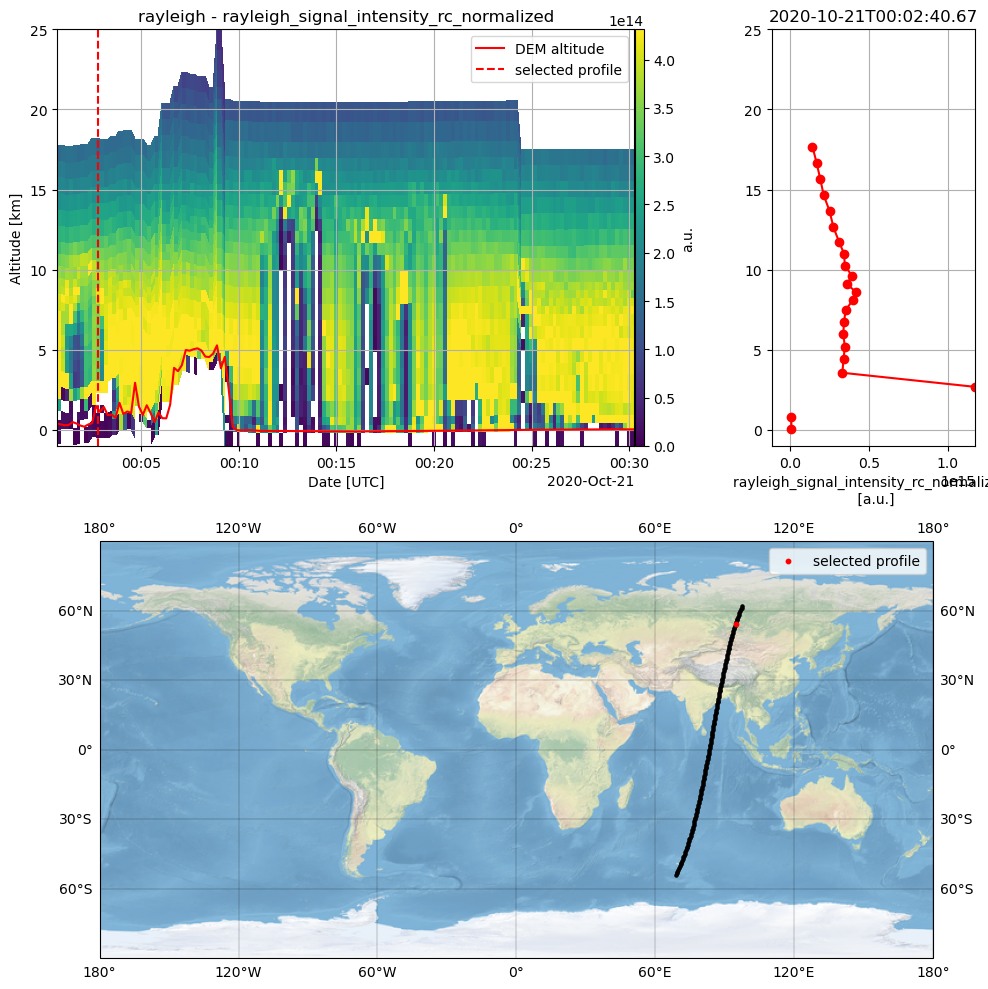

interactive(children=(SelectionSlider(continuous_update=False, description='Profile time', index=10, layout=La…

In [13]:
L1B_plot.select_parameter("rayleigh_signal_intensity_rc_normalized")

## apply QC filter
# L1B_plot.apply_QC_filter()

## apply filter based on SNR
L1B_plot.apply_SNR_filter(SNR_threshold=10)

## plot 2D curtain plot
# L1B_plot.plot_2D()

## plot profile plot
# L1B_plot.plot_profile(profile_time='2020-08-07T16:49:00', no_profiles_avg=0)

## plot interactive
L1B_plot.plot_interactive()

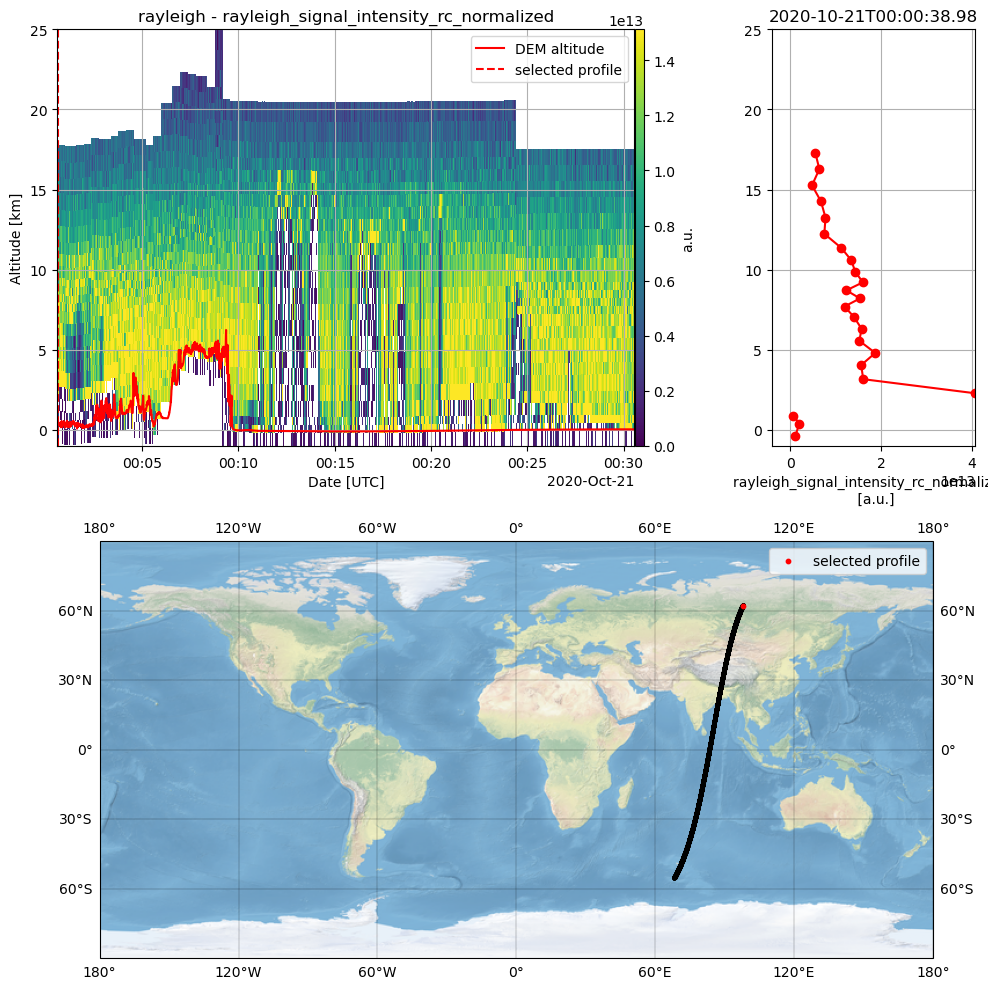

interactive(children=(SelectionSlider(continuous_update=False, description='Profile time', index=10, layout=La…

In [14]:
L1B_plot = PlotData(granularity="measurement")
L1B_plot.select_parameter("rayleigh_signal_intensity_rc_normalized")
L1B_plot.apply_SNR_filter(SNR_threshold=3)
L1B_plot.plot_interactive()